In [17]:
import random
import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt

# Environment

In [2]:
class FrozenLake:
    def __init__(self, size, holes, slippery=True):
        self.size = size 
        self.slippery = slippery
        self.actions = [0, 1, 2, 3]  # 0: left, 1: down, 2: right, 3: up
        self.state = 0  # Start at top-left corner
        self.goal = self.size * self.size - 1  # Goal at bottom-right corner
        self.holes = holes 
        
        self.slip_effects = {
            0: [-1, self.size, -self.size],  # Left slip effects: left, down, up
            1: [self.size, -1, 1],  # Down slip effects: down, left, right
            2: [1, self.size, -self.size],  # Right slip effects: right, down, up
            3: [-self.size, -1, 1],  # Up slip effects: up, left, right
        }

    def reset(self):
        self.state = 0
        return self.state, {}

    def step(self, action):
        assert action in self.actions, "Invalid action"

        # apply slip effect
        if self.slippery:
            action_effect = np.random.choice(self.slip_effects[action])
        else:
            action_effect = [-1, self.size, 1, -self.size][action]

        # calculate next state
        next_state = self.state + action_effect

        # check for boundary conditions
        if next_state < 0 or next_state >= self.size * self.size:
            next_state = self.state
        elif action == 0 and next_state % self.size == self.size - 1:
            next_state = self.state
        elif action == 2 and next_state % self.size == 0:
            next_state = self.state

        done = next_state == self.goal or next_state in self.holes
        reward = 1 if next_state == self.goal else 0 
        self.state = next_state

        return next_state, reward, done, False, {}

    def render(self):
        grid = np.array(["F"] * self.size * self.size)
        grid[list(self.holes)] = "H"
        grid[self.goal] = "G"
        grid[self.state] = "S"
        print("\n".join("".join(grid[i:i+self.size]) for i in range(0, self.size*self.size, self.size)))

In [3]:
env = FrozenLake(size=8, holes=set([19, 29, 35, 41, 42, 47, 48, 51, 53, 59]), slippery=True)
env.render()

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFFH
HFFHFHFF
FFFHFFFG


# Q-Learning agent

In [4]:
class QLearningAgent:
    def __init__(self, action_size, state_size, learning_rate=0.01, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.action_size = action_size
        self.state_size = state_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((state_size, action_size))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(range(self.action_size))
        else:
            return np.argmax(self.q_table[state])

    def act_exploit(self, state):
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target += self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action] += self.learning_rate * (target - self.q_table[state, action])

        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def train(self, env, episodes=1000):
        rewards = []
        for episode in tqdm(range(episodes)):
            state, _ = env.reset()
            total_reward = 0
            done = False
            
            while not done:
                action = self.act(state)
                next_state, reward, done, truncated, _ = env.step(action)
                self.learn(state, action, reward, next_state, done)
                
                state = next_state
                total_reward += reward
            
            rewards.append(total_reward)
        return rewards


    def exploit(self, env):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = self.act_exploit(state)
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            state = next_state
        
        return total_reward

In [165]:
TRAIN_EPISODES = 10_000
EXPLOIT_EPISODES = 10_000

In [185]:
env = FrozenLake(size=8, holes=set([19, 29, 35, 41, 42, 47, 48, 51, 53, 59]), slippery=True)
state_size = env.size * env.size 
action_size = len(env.actions)
q_agent = QLearningAgent(
    action_size=action_size,
    state_size=state_size,
    learning_rate=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.01
)

In [186]:
qagent_train_rewards = q_agent.train(env, episodes=TRAIN_EPISODES)

100%|███████████████████████████████████| 10000/10000 [00:04<00:00, 2331.10it/s]


In [187]:
np.mean(qagent_train_rewards)

0.1039

In [188]:
qagent_exploit_rewards = []
for _ in tqdm(range(EXPLOIT_EPISODES)):
    qagent_exploit_rewards.append(q_agent.exploit(env))    

100%|███████████████████████████████████| 10000/10000 [00:03<00:00, 2753.36it/s]


In [189]:
np.mean(qagent_exploit_rewards)

0.193

# Dyna Q agent

In [176]:
class DynaQAgent:
    def __init__(self, action_size, state_size, learning_rate=0.01, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, planning_steps=10):
        self.action_size = action_size
        self.state_size = state_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((state_size, action_size))
        self.model = {}  
        self.planning_steps = planning_steps

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(range(self.action_size))  
        else:
            return np.argmax(self.q_table[state]) 

    def act_exploit(self, state):
        return np.argmax(self.q_table[state]) 

    def learn(self, state, action, reward, next_state, done):
        # update Q-table with real experience
        target = reward
        if not done:
            target += self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action] += self.learning_rate * (target - self.q_table[state, action])
        
        if (state, action) not in self.model:
            self.model[(state, action)] = {}
        if (next_state, reward) not in self.model[(state, action)]:
            self.model[(state, action)][(next_state, reward)] = 1
        else:
            self.model[(state, action)][(next_state, reward)] += 1

        for _ in range(self.planning_steps):
            if not self.model:
                break
            sim_state, sim_action = random.choice(list(self.model.keys()))
            observations = list(self.model[(sim_state, sim_action)].items())
            next_states_rewards, counts = zip(*observations)
            sim_next_state, sim_reward = next_states_rewards[np.random.choice(range(len(next_states_rewards)), p=np.array(counts)/np.sum(counts))]
            
            sim_target = sim_reward + self.gamma * np.max(self.q_table[sim_next_state])
            self.q_table[sim_state, sim_action] += self.learning_rate * (sim_target - self.q_table[sim_state, sim_action])

        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def train(self, env, episodes=1000):
        rewards = []
        for episode in tqdm(range(episodes)):
            state, _ = env.reset()
            total_reward = 0
            done = False
            
            while not done:
                action = self.act(state)
                next_state, reward, done, truncated, _ = env.step(action)
                self.learn(state, action, reward, next_state, done)
                
                state = next_state
                total_reward += reward
            
            rewards.append(total_reward)
        return rewards

    def exploit(self, env):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = self.act_exploit(state)
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            state = next_state
        
        return total_reward

In [213]:
env = FrozenLake(size=8, holes=set([19, 29, 35, 41, 42, 47, 48, 51, 53, 59]), slippery=True)
dynaq_agent = DynaQAgent(
    action_size=action_size,
    state_size=state_size,
    learning_rate=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.01,
    planning_steps=10
)

In [214]:
dynaq_train_rewards = dynaq_agent.train(env, episodes=TRAIN_EPISODES)

100%|█████████████████████████████████████| 10000/10000 [02:16<00:00, 73.24it/s]


In [215]:
print(np.mean(dynaq_train_rewards))

0.3752


In [216]:
dynaq_exploit_rewards = []

for _ in tqdm(range(EXPLOIT_EPISODES)):
    dynaq_exploit_rewards.append(dynaq_agent.exploit(env))  

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1916.76it/s]


In [217]:
print(np.mean(dynaq_exploit_rewards))

0.3695


# Rewards

In [218]:
train_df = pd.DataFrame(
    {
        "ql": qagent_train_rewards,
        "dynaq": dynaq_train_rewards
    }
)

exploit_df = pd.DataFrame(
    {
        "ql": qagent_exploit_rewards,
        "dynaq": dynaq_exploit_rewards
    }
)

In [219]:
train_df["ql_mean_100"] = train_df["ql"].rolling(100).mean()
train_df["dynaq_mean_100"] = train_df["dynaq"].rolling(100).mean()

exploit_df["ql_mean_100"] = exploit_df["ql"].rolling(100).mean()
exploit_df["dynaq_mean_100"] = exploit_df["dynaq"].rolling(100).mean()

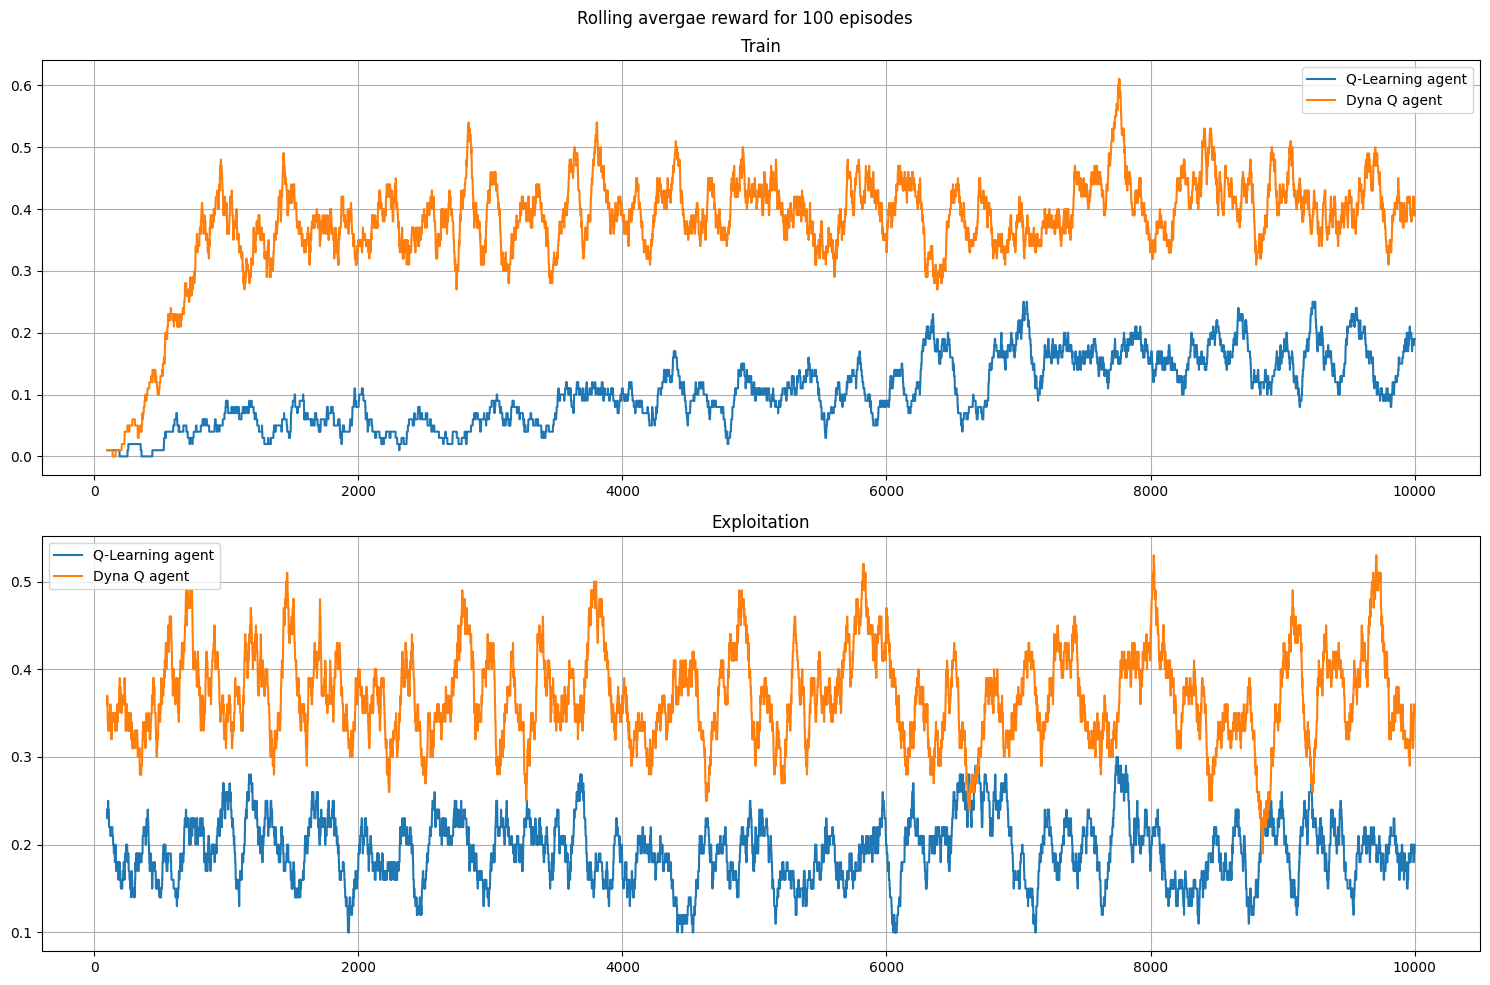

In [220]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

ax[0].plot(train_df["ql_mean_100"], label="Q-Learning agent")
ax[0].plot(train_df["dynaq_mean_100"], label="Dyna Q agent")
ax[0].set_title("Train") 

ax[1].plot(exploit_df["ql_mean_100"], label="Q-Learning agent")
ax[1].plot(exploit_df["dynaq_mean_100"], label="Dyna Q agent")
ax[1].set_title("Exploitation")

for i in range(2):
    ax[i].grid()
    ax[i].legend()

fig.suptitle("Rolling avergae reward for 100 episodes")
fig.tight_layout()
plt.show()